In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o", temperature=0)
small_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

In [3]:
# 마켓 조사 Agent
# 주식 조사 Agent (차트)
# 재무제표 Agent

In [ ]:
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command
from langgraph.graph import END, MessagesState
from typing import Literal

from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper

# state_modifier 로 페르소나 부여
polygon = PolygonAPIWrapper()
toolkit = PolygonToolkit.from_polygon_api_wrapper(polygon)
polygon_tools = toolkit.get_tools()
market_research_tools = [YahooFinanceNewsTool()] + polygon_tools
market_research_agent = create_react_agent(llm, tools=market_research_tools, state_modifier="You are a market researcher. Provide fact only not opinion.")

def market_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = market_research_agent.invoke(state)
    # print(f"market_research_node: {result}")
    
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="market_research")]},
        goto="supervisor"
    )

In [18]:
from langchain.tools import tool
import yfinance as yf

@tool
def get_stock_price(ticker: str) -> dict:
    """Given a stock ticker, return the price data for the past month"""
    stock_info = yf.download(ticker, period='1mo').to_dict()
    return stock_info
    

stock_research_tools = [get_stock_price]
stock_research_agent = create_react_agent(small_llm, tools=stock_research_tools, state_modifier="You are a stock researcher. Provide fact only not opinion.")

def stock_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = stock_research_agent.invoke(state)
    # print(f"stock_research_node: {result}")
    
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="stock_research")]},
        goto="supervisor"
    )

In [8]:
get_stock_price("AAPL")

/tmp/ipykernel_2873776/2981273689.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_info = yf.download(ticker, period='1mo').to_dict()
[*********************100%***********************]  1 of 1 completed


{('Close', 'AAPL'): {Timestamp('2025-07-14 00:00:00'): 208.3834991455078,
  Timestamp('2025-07-15 00:00:00'): 208.87295532226562,
  Timestamp('2025-07-16 00:00:00'): 209.92176818847656,
  Timestamp('2025-07-17 00:00:00'): 209.78192138671875,
  Timestamp('2025-07-18 00:00:00'): 210.9405975341797,
  Timestamp('2025-07-21 00:00:00'): 212.23912048339844,
  Timestamp('2025-07-22 00:00:00'): 214.15695190429688,
  Timestamp('2025-07-23 00:00:00'): 213.9072265625,
  Timestamp('2025-07-24 00:00:00'): 213.51766967773438,
  Timestamp('2025-07-25 00:00:00'): 213.63754272460938,
  Timestamp('2025-07-28 00:00:00'): 213.80735778808594,
  Timestamp('2025-07-29 00:00:00'): 211.03050231933594,
  Timestamp('2025-07-30 00:00:00'): 208.81301879882812,
  Timestamp('2025-07-31 00:00:00'): 207.33470153808594,
  Timestamp('2025-08-01 00:00:00'): 202.1505889892578,
  Timestamp('2025-08-04 00:00:00'): 203.11949157714844,
  Timestamp('2025-08-05 00:00:00'): 202.68995666503906,
  Timestamp('2025-08-06 00:00:00'): 

In [33]:
@tool
def company_research_tool(ticker: str) -> dict:
    """Given a ticker, return the company information"""
    
    company_info = yf.Ticker(ticker)
    finacial_info = company_info.get_financials()
    sec_filings = company_info.get_sec_filings()
    
    return {
        "finacial_info": finacial_info,
        "sec_filings": sec_filings
    }
    
company_research_tools = [company_research_tool]
company_research_agent = create_react_agent(llm, tools=company_research_tools, state_modifier="You are a company researcher. Provide fact only not opinion.")

def company_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = company_research_agent.invoke(state)
    # print(f"company_research_node: {result}")
    
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="company_research")]},
        goto="supervisor"
    )

In [ ]:
from langchain_core.prompts import PromptTemplate

analyst_prompt = PromptTemplate.from_template("""You are a stock market analyst. Given the following information,
                                              Please provide a summary of the messages and a recommendation for the user.
                                              
                                              Information:
                                              {messages}""")

analyst_chain = analyst_prompt | llm
def analyst_node(state: MessagesState):
    result = analyst_chain.invoke({"messages": state["messages"][1:]})
    return {"messages": [HumanMessage(content=result.content, name="analyst")]}

In [41]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["market_research", "stock_research", "company_research"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



def supervisor_node(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    """
    supervisor node입니다. 주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정합니다. 모든 작업이 완료되면 analyst node로 이동합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령을 반환합니다.
    """
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"

    return Command(goto=goto)

In [47]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(MessagesState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("market_research", market_research_node)
graph_builder.add_node("stock_research", stock_research_node)
graph_builder.add_node("company_research", company_research_node)
graph_builder.add_node("analyst", analyst_node)


In [48]:
graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)
# Conditional로 모두 처리되어있어서 나머지는 필요없음
graph = graph_builder.compile()

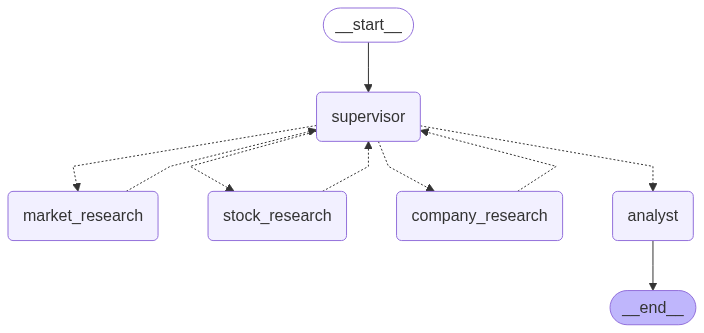

In [49]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
for chunk in graph.stream({"messages": ["user", "Would you invest in Snowflake?"]}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Would you invest in Snowflake?
================================ Human Message =================================
Name: market_research

As an AI language model, I don't have personal opinions or the ability to invest. However, I can help you gather information to make an informed decision. If you're considering investing in Snowflake, it's important to look at various factors such as the company's financial health, market position, growth potential, and recent news.

Would you like me to find the latest financial news about Snowflake to help you with your decision?
================================ Human Message =================================
Name: company_research

Here's some financial information and recent SEC filings for Snowflake (Ticker: SNOW) that might help you in making an investment decision:

### Financial Information (as of January 31, 2025):
- **Total Revenue**: $3.63 billion
- **Gross Prof

/tmp/ipykernel_2873776/2996360681.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_info = yf.download(ticker, period='1mo').to_dict()
[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: stock_research

Here's a summary of the financial information and recent stock performance for Snowflake (Ticker: SNOW) to help you in your investment decision:

### Financial Overview (as of January 31, 2025):
- **Total Revenue**: $3.63 billion
- **Gross Profit**: $2.41 billion
- **Operating Income**: -$1.46 billion
- **Net Income**: -$1.29 billion
- **EBITDA**: -$1.10 billion
- **Research and Development Expenses**: $1.78 billion
- **Selling, General, and Administrative Expenses**: $2.08 billion
- **Diluted EPS**: -$3.86

### Recent SEC Filings:
1. **8-K (Corporate Changes & Voting Matters)** - July 3, 2025
2. **10-Q (Periodic Financial Reports)** - May 30, 2025
3. **DEF 14A (Proxy Statements)** - May 21, 2025
4. **10-K (Annual Report)** - March 21, 2025

### Stock Performance (Last Month):
- **Current Price**: $191.80 (as of August 11, 2025)
- **Price Range**: 
  - **High**: $229.27 (July 31, 2025